In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle
import signac
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
from textwrap import fill

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

#Ignore inconcistent version warning
import warnings
# from sklearn.exceptions import InconsistentVersionWarning
# warnings.filterwarnings(action='ignore', category=InconsistentVersionWarning)
import gpflow
import tensorflow_probability as tfp

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-08 16:36:49.154510: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 16:36:49.213726: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 16:36:49.213789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 16:36:49.216008: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to 

In [2]:
#Make Simulator and Training Data
cs_name_val = 15
noise_mean = 0
noise_std = None
seed = 1
#Define method, ep_enum classes, indecies to consider, and kernel
meth_name = Method_name_enum(3)
method = GPBO_Methods(meth_name)
gen_meth_theta = Gen_meth_enum(1)
gen_meth_x = Gen_meth_enum(2)
num_x_data = 10

#Define Simulator Class (Export your Simulator Object Here)
simulator = simulator_helper_test_fxns(cs_name_val, noise_mean, noise_std, seed)
num_theta_data = len(simulator.indeces_to_consider)*10
#Generate Exp Data (OR Add your own experimental data as a Data class object)
set_seed = 1 #Set set_seed to 1 for data generation
gen_meth_x = Gen_meth_enum(gen_meth_x)
exp_data = simulator.gen_exp_data(num_x_data, gen_meth_x, set_seed)
#Set simulator noise_std artifically as 5% of y_exp mean (So that noise will be set rather than trained)
simulator.noise_std = np.abs(np.mean(exp_data.y_vals))*0.05
print(simulator.noise_std)
#Note at present, training data is always the same between jobs since we set the data generation seed to 1
sim_data = simulator.gen_sim_data(num_theta_data, num_x_data, gen_meth_theta, gen_meth_x, 1.0, seed, False)
val_data = simulator.gen_sim_data(10, 10, Gen_meth_enum(1), Gen_meth_enum(1), 1.0, simulator.seed, False)
# print(sim_data.theta_vals)
all_gp_data = sim_data
all_val_data = val_data

if method.emulator == True:
    all_gp_data = sim_data
    all_val_data = val_data
else:
    all_gp_data = simulator.sim_data_to_sse_sim_data(method, sim_data, exp_data, 1.0, False)
    print(len(all_gp_data.theta_vals), len(all_gp_data.x_vals), len(all_gp_data.y_vals))
    all_val_data = simulator.sim_data_to_sse_sim_data(method, val_data, exp_data, 1.0, False)
    print(len(all_val_data.theta_vals), len(all_val_data.x_vals), len(all_val_data.y_vals))

0.03933441509013034


In [3]:
#Test GPs
#Make CS Params
retrain_GP = 5
normalize = True
noise_std = simulator.noise_std #Yexp_std is exactly the noise_std of the GP Kernel
print(noise_std)

#Make Emulator
#Evaluate GP Mean and Variance
# gp_object = Type_1_GP_Emulator(all_gp_data, all_val_data, None, None, None, Kernel_enum(1), None, noise_std, None, 
#                                 retrain_GP, seed, normalize, None, None, None, None)
gp_object = Type_2_GP_Emulator(all_gp_data, all_val_data, None, None, None, Kernel_enum(1), None, noise_std, None, 
                                retrain_GP, seed, normalize, None, None, None, None)
#Choose training data
train_data, test_data = gp_object.set_train_test_data(1.0, seed)
gp_object.scalerY = gp_object.scalerY.fit(gp_object.train_data.y_vals.reshape(-1,1))
gp_object.scalerX = gp_object.scalerX.fit(gp_object.feature_train_data)
print(gp_object.scalerY.scale_)

0.03933441509013034
[0.17995484]


In [4]:
scl_feat_data = gp_object.scalerX.transform(gp_object.feature_train_data)
scl_y_data = gp_object.scalerY.transform(gp_object.train_data.y_vals.reshape(-1,1))

In [74]:
#Get lengthscale min and max differences
#Transform X data
points = gp_object.scalerX.transform(gp_object.train_data_init)
# Compute pairwise differences for each column
pairwise_diffs = np.abs(points[:, :, None] - points[:, :, None].transpose(0, 2, 1))
# Compute Euclidean distances
euclidean_distances = np.sqrt(np.sum(pairwise_diffs ** 2, axis=1))
# Set diagonal elements (distance between the same point) to infinity
np.fill_diagonal(euclidean_distances, np.inf)
euclidean_distances = np.ma.masked_invalid(euclidean_distances)
# Find the smallest/largest distance for each column
min_distance = np.min(euclidean_distances, axis=0)
max_distance = np.max(euclidean_distances, axis=0)
# min_distance = np.min(euclidean_distances)
# max_distance = np.max(euclidean_distances)
d_guess = np.average((min_distance, max_distance), axis = 0)
print(d_guess)
print(min_distance)
print(max_distance)

[2.96692697 2.40983505 2.53139285 2.59024246 2.50417072 2.68472865]
[0.958681881745898 0.5123836052410905 0.7681520157544306
 0.49603570886160264 0.6475178072897967 0.5052984160539546]
[4.975172056375217 4.307286492903804 4.2946336793957025 4.684449215905155
 4.360823628438143 4.864158883651743]


In [80]:

y = gp_object.scalerY.transform(sim_data.y_vals.reshape(-1,1))
c_guess= sum(y.flatten()**2)/len(y)
mat_kern = gpflow.kernels.Matern52(variance = c_guess, lengthscales=d_guess)
noise_kern = gpflow.kernels.White(variance=float((noise_std/gp_object.scalerY.scale_)**2))
kernel = mat_kern+noise_kern

#Set scale parameter as Constant
gp_model =gpflow.models.GPR((scl_feat_data, scl_y_data),
        kernel=kernel, noise_variance = float((noise_std/gp_object.scalerY.scale_)**2)
    )
# gpflow.set_trainable(gp_model.likelihood.variance, False)
if gp_object.outputscl is not None:
    gpflow.set_trainable(mat_kern.variance, False)
mat_kern.variance.prior = tfp.distributions.HalfCauchy(np.float64(1.0), np.float64(5.0))
if gp_object.noise_std is not None:
    gpflow.set_trainable(gp_model.kernel.kernels[1].variance, False)

gpflow.utilities.print_summary(gp_model)
#######################################################
# import tensorflow_probability as tfp
# y = gp_object.scalerY.transform(sim_data.y_vals.reshape(-1,1))
# c_guess= sum(y.flatten()**2)/len(y)
# mat_kern = gpflow.kernels.Matern52(variance = c_guess, lengthscales=max_distance)
# per_kern = gpflow.kernels.Periodic(base_kernel = mat_kern, period = 1.0)
# noise_kern = gpflow.kernels.White(variance = float((noise_std/gp_object.scalerY.scale_)**2))
# kernel = per_kern+noise_kern

# #Set scale parameter as Constant
# gp_model =gpflow.models.GPR((scl_feat_data, scl_y_data),
#         kernel=kernel, noise_variance = float((noise_std/gp_object.scalerY.scale_)**2)
#     )
# # gpflow.set_trainable(gp_model.likelihood.variance, False)
# if gp_object.outputscl is not None:
#     gpflow.set_trainable(mat_kern.variance, False)
# if gp_object.noise_std is not None:
#     gpflow.set_trainable(noise_kern.variance, False)

# gpflow.utilities.print_summary(gp_model)

╒════════════════════════════════════╤═══════════╤══════════════════╤════════════╤═════════════╤═════════╤═════════╤═══════════════════════════════╕
│ name                               │ class     │ transform        │ prior      │ trainable   │ shape   │ dtype   │ value                         │
╞════════════════════════════════════╪═══════════╪══════════════════╪════════════╪═════════════╪═════════╪═════════╪═══════════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │ HalfCauchy │ True        │ ()      │ float64 │ 2.06743                       │
├────────────────────────────────────┼───────────┼──────────────────┼────────────┼─────────────┼─────────┼─────────┼───────────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │            │ True        │ (6,)    │ float64 │ [2.96693, 2.40984, 2.53139... │
├────────────────────────────────────┼───────────┼──────────────────┼────────────┼─────────────┼─────────┼

In [76]:
#Train GP
# optimizer = gpflow.optimizers.Scipy()
# optimizer.minimize(gp_model.training_loss, gp_model.trainable_variables)
# print(gp_model.trainable_parameters.numpy())
# Number of retraining iterations
print(gp_model.parameters[0].numpy())
num_retrainings = 1

# Train the model multiple times and keep track of the model with the lowest minimum training loss
best_minimum_loss = float('inf')
optimizer = gpflow.optimizers.Scipy()
best_model = None

for _ in range(num_retrainings):
    # Define and train the GP model
    optimizer.minimize(gp_model.training_loss, gp_model.trainable_variables)

    # Compute the training loss of the model
    training_loss = gp_model.training_loss().numpy()

    # Check if this model has the best minimum training loss
    if training_loss < best_minimum_loss:
        best_minimum_loss = training_loss
        best_model = gp_model

gpflow.utilities.print_summary(gp_model)

[2.96692697 2.40983505 2.53139285 2.59024246 2.50417072 2.68472865]
╒════════════════════════════════════╤═══════════╤══════════════════╤════════════╤═════════════╤═════════╤═════════╤══════════════════════════════════╕
│ name                               │ class     │ transform        │ prior      │ trainable   │ shape   │ dtype   │ value                            │
╞════════════════════════════════════╪═══════════╪══════════════════╪════════════╪═════════════╪═════════╪═════════╪══════════════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │ HalfCauchy │ True        │ ()      │ float64 │ 1.87354                          │
├────────────────────────────────────┼───────────┼──────────────────┼────────────┼─────────────┼─────────┼─────────┼──────────────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │            │ True        │ (6,)    │ float64 │ [4.39033, 1.67004, 0.38665027... │
├───────────────────

In [77]:
X_scld = gp_object.scalerX.transform(gp_object.feature_val_data)
gp_mean, gp_var = gp_model.predict_f(X_scld)
misc_gp_mean = gp_object.scalerY.inverse_transform(gp_mean.numpy()).flatten()
misc_var_return = gp_var.numpy().flatten()*gp_object.scalerY.scale_**2

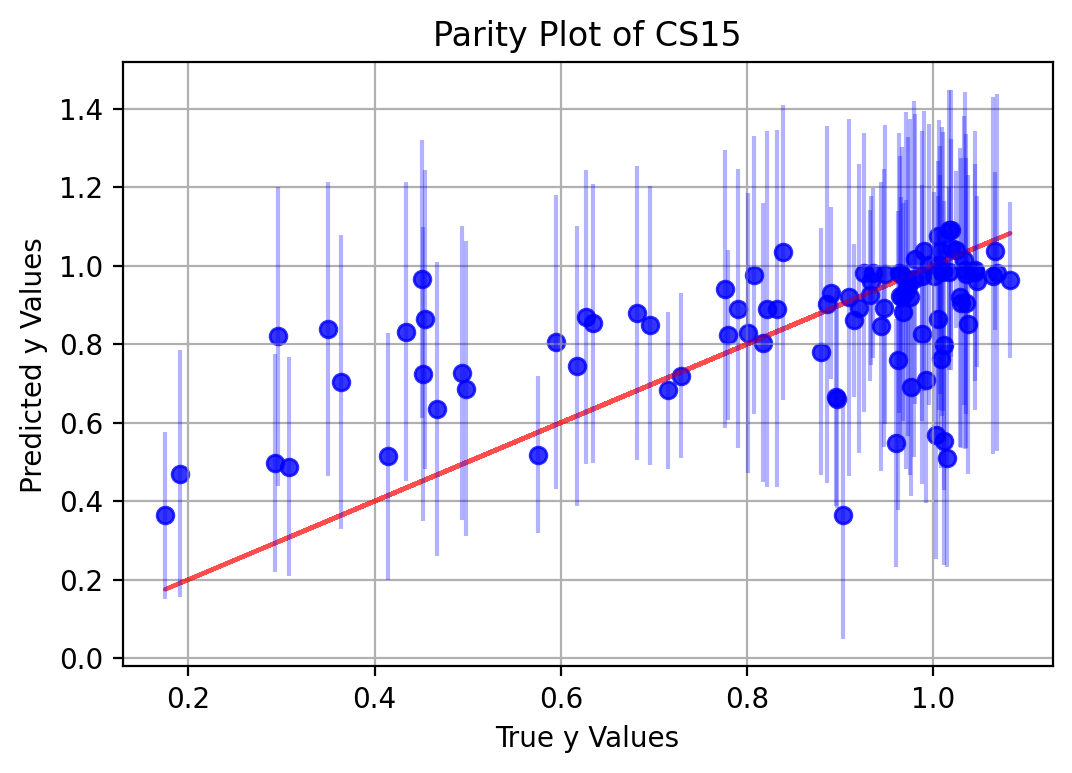

In [78]:
plt.figure()
plt.plot(all_val_data.y_vals, all_val_data.y_vals, color='red', alpha=0.7)
plt.scatter(all_val_data.y_vals, misc_gp_mean, color='blue', alpha=0.7)
plt.errorbar(all_val_data.y_vals, misc_gp_mean, yerr = 1.96*np.sqrt(abs(misc_var_return)), alpha=0.3, fmt = 'o', color = "blue")
plt.xlabel('True y Values')
plt.ylabel('Predicted y Values')
# plt.xlim([-10,10])
plt.title('Parity Plot of CS' + str(cs_name_val))
plt.grid(True)
plt.show()